In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
import scipy
import os
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import QuantileRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import glob

Notebook for conducting downscaling on all the other different weather variables (pressure, humidity, etc).

## Importing Training Data

In [2]:
p1 = '/results/forcing/atmospheric/GEM2.5/gemlam/gemlam_y2007m01d03.nc'
d1 = xr.open_dataset(p1)
list(d1.keys())

['atmpres',
 'percentcloud',
 'PRATE_surface',
 'nav_lat',
 'nav_lon',
 'precip',
 'qair',
 'RH_2maboveground',
 'solar',
 'tair',
 'therm_rad',
 'u_wind',
 'v_wind']

In [3]:
myFiles = glob.glob('/home/arandhawa/*') # returns list
myFiles.sort()
myFiles

['/home/arandhawa/Miniforge3-Linux-x86_64.sh',
 '/home/arandhawa/canrcm_2007_uas.nc',
 '/home/arandhawa/canrcm_2007_vas.nc',
 '/home/arandhawa/canrcm_2008_uas.nc',
 '/home/arandhawa/canrcm_2008_vas.nc',
 '/home/arandhawa/canrcm_huss_2007.nc',
 '/home/arandhawa/canrcm_huss_2008.nc',
 '/home/arandhawa/canrcm_pr_2007.nc',
 '/home/arandhawa/canrcm_pr_2008.nc',
 '/home/arandhawa/canrcm_psl_2007.nc',
 '/home/arandhawa/canrcm_psl_2008.nc',
 '/home/arandhawa/canrcm_rlds_2007.nc',
 '/home/arandhawa/canrcm_rlds_2008.nc',
 '/home/arandhawa/canrcm_rsds_2007.nc',
 '/home/arandhawa/canrcm_rsds_2008.nc',
 '/home/arandhawa/canrcm_tas_2007.nc',
 '/home/arandhawa/canrcm_tas_2008.nc',
 '/home/arandhawa/conda_envs',
 '/home/arandhawa/miniforge3']

| Description | HRDPS       | CANRCM      | 
| ----------- | ----------- | ----------- |
| Near-Surface Air Temperature | tair | tas |
| Precipitation | precip | pr |
| Sea Level Pressure | atmpres | psl |
| Near Surface Specific Humidity | qair | huss |
| Shortwave radiation | solar | rsds |
| Longwave radiation | therm_rad | rlds |

In [207]:
name = 'Precipitation'

In [214]:
data_name = 'therm_rad'    ##variable of HRDPS data to work with

In [215]:
p_can07 = '/home/arandhawa/canrcm_rlds_2007.nc'   ##variables of CANRCM data
p_can08 = '/home/arandhawa/canrcm_rlds_2008.nc'
data_name_can = 'rlds'

In [216]:
##2007 HRDPS import

files = glob.glob('/results/forcing/atmospheric/GEM2.5/gemlam/gemlam_y2007m??d??.nc')
##list of data files, febrary 2007 - each file covers one day, with hourly data
##the grid is 266 by 256 points, with resolution 2.5km
##relevant data in this file is u_wind and v_wind data
files.sort()
print(len(files))

## 3-hour averaged matrix

hr07 = np.empty( (8*len(files), 266, 256)) 

for i in range(len(files)):
    dayX = xr.open_dataset(files[i])
    ##adding 1 day of 3-hour averages to new data array
    hr07[8*i:8*i + 8,:,:] = np.array( dayX[ data_name ] ).reshape(8, 3, 266, 256).mean(axis = 1) 

del dayX

print(hr07.shape)

363
(2904, 266, 256)


In [217]:
##CANRCM 2007 import
d1 = xr.open_dataset(p_can07)
can07 = d1[data_name_can][16:,140:165,60:85] ##the first two days are removed to be consistent with 2007 HRDPS

print(can07.shape)

(2904, 25, 25)


## PCA Functions

In [218]:
##transforms and concatenates two data sets
def transform2(data1, data2):
    A_mat = transform(data1)
    B_mat = transform(data2)
    return np.concatenate((A_mat, B_mat), axis=0) 

In [219]:
##inverse function of transform2 - splits data matrix and returns two data sets
def reverse2(matrix, orig_shape):
    split4 = int( matrix.shape[0]/2 )
    u_data = reverse(matrix[:split4,:], orig_shape) ##reconstructing u_winds from n PCs
    v_data = reverse(matrix[split4:,:], orig_shape) ##reconstructing v_winds from n PCs
    return (u_data, v_data)

In [220]:
##performs PCA analysis using sklearn.pca
def doPCA(comp, matrix):
    pca = PCA(n_components = comp) ##adjust the number of principle conponents to be calculated
    PCs = pca.fit_transform(matrix)
    eigvecs = pca.components_
    mean = pca.mean_
    return (PCs, eigvecs, mean)

In [221]:
##data must be converted into a 2D matrix for pca analysis
##transform takes a 3D data array (time, a, b) -> (a*b, time)
##(the data grid is flattened a column using numpy.flatten)

def transform(xarr):
    arr = np.array(xarr) ##converting to numpy array
    arr = arr.reshape(arr.shape[0], arr.shape[1]*arr.shape[2]) ##reshaping from size (a, b, c) to (a, b*c)
    arr = arr.transpose()
    return arr

def reverse(mat, orig_shape):
    arr = np.copy(mat)
    arr = arr.transpose()
    arr = arr.reshape(-1, orig_shape[1], orig_shape[2]) ##reshaping back to original array shape
    return arr

In [222]:
##graphing percentage of original data represented by the first n principle conponents
def graph_variance(matrix, n):
    pcaG = PCA(n_components = n) ##Number of principle conponents to show
    PCsG = pcaG.fit_transform(matrix)
    plt.plot(np.cumsum(pcaG.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance');
    plt.show()
    del pcaG
    del PCsG

In [223]:
##can be used to visualize principle conponents for u/v winds
def graph_nPCs(PCs, eigvecs, n, orig_shape):
    fig, ax = plt.subplots(n, 3, figsize=(10, 3*n))
    
    ax[0, 0].set_title("u-conponent")
    ax[0, 1].set_title("v-component")
    ax[0, 2].set_title("time-loadings")
    
    for i in range(n):
        mode_u, mode_v = get_mode(PCs, i, orig_shape)
        colors = ax[i, 0].pcolormesh(mode_u, cmap = 'bwr')
        fig.colorbar(colors, ax = ax[i,0])
        colors = ax[i, 1].pcolormesh(mode_v, cmap = 'bwr')
        fig.colorbar(colors, ax = ax[i,1])
        ax[i, 2].plot(eigvecs[i])

    plt.tight_layout()
    plt.show()

##converts PCs (column vectors) to 2d conpoents for u and v wind
def get_mode(PCs, n, orig_shape): 
    split = int(PCs.shape[0]/2)
    mode_u = PCs[:split, n].reshape(orig_shape[1], orig_shape[2])
    mode_v = PCs[split:, n].reshape(orig_shape[1], orig_shape[2])
    return (mode_u, mode_v)



## PCAs on Training Data

In [224]:
##PCA on CANRCM 2007
can07_mat = transform(can07)
can07_PCs, can07_eigs, can07_mean = doPCA(100, can07_mat)

##PCA on HRDPS 2007
hr07_mat = transform(hr07)
hr07_PCs, hr07_eigs, hr07_mean = doPCA(100, hr07_mat)

In [225]:
## combining the eigenvectors and mean together in one array for analysis
## the mean is the average value at each timestamp (average row) - behaves as a zeroth eigenvector
can07_me = np.concatenate((can07_mean.reshape(1, -1), can07_eigs))
hr07_me = np.concatenate((hr07_mean.reshape(1, -1), hr07_eigs))

In [226]:
del hr07
del can07

## Multiple Linear Regression Functions

In [227]:
##functions that use multiple linear regression to fit eigenvectors
##takes CANRCM eigenvectors (x1, x2, x3, x4...) and HRDPS eigenvectors (y1, y2, y3...)
##For each y from 0:result_size, approximates yn = a0 + a1*x1 + a2*x2 + a3*x3 ... using num_vec x's
##getCoefs returns (coeficients, intercept)
##fit_modes returns each approximation and the R^2 value of each fit as (results, scores)

def getCoefs(vectors, num_vec, data, num_modes, type = 'LS'):  
    
    X = vectors[0:num_vec,:].T
    coefs = np.zeros((num_modes, X.shape[1]))
    intercept = np.zeros(num_modes)
    
    if type == 'LS':
        for i in range(num_modes):
            y = data[i,:]
            reg = LinearRegression().fit(X, y)
            coefs[i] = reg.coef_[0:num_vec]
            intercept[i] =  reg.intercept_
    elif type == 'MAE':
        for i in range(num_modes):
            y = data[i,:]
            reg = QuantileRegressor(quantile = 0.5, alpha = 0, solver = 'highs').fit(X, y)
            coefs[i] = reg.coef_[0:num_vec]
            intercept[i] =  reg.intercept_
    
    return (coefs, intercept)


def fit_modes(vectors, num_vec, data, result_size, type = 'LS'):  
    
    X = vectors[0:num_vec,:].T
    result = np.zeros((result_size, X.shape[0]))
    scores = np.zeros(result_size)
    
    if type == 'LS':
        for i in range(result_size):
            y = data[i,:]
            reg = LinearRegression().fit(X, y)
            result[i] = reg.predict(X)
            scores[i] = reg.score(X, y)
            
    elif type == 'MAE':
        for i in range(result_size):
            y = data[i,:]
            reg = QuantileRegressor(quantile = 0.5, alpha = 0, solver = 'highs').fit(X, y)
            result[i] = reg.predict(X)
            scores[i] = reg.score(X, y)
    
    return (result, scores)


In [228]:
##returns the ratio of the average energy between two sets of eigenvectors (element-wise)
##"energy" is defined as value^2 - two sets of eigenvectors with the same "energy" would
##recreate data with approximately the same kinetic energy (v^2)

def getEnergyCoefs(eigs, old_eigs):
    coefs = np.sqrt( (old_eigs[0:eigs.shape[0]]**2).mean(axis = 1)/(eigs**2).mean(axis = 1))
    return coefs

## Importing data for downscaling

In [229]:
##supposed to be 2008 canrcm data
d1 = xr.open_dataset(p_can08)

In [230]:
##duplicating feb 28 twice to account for leap year (feb 29th is missing in CANRCM)
can08 = np.concatenate((d1[data_name_can][:472,140:165,60:85], d1[data_name_can][464:472,140:165,60:85], d1[data_name_can][472:,140:165,60:85] ))

In [231]:
##not duplicating feb 28 twice - for 2007
##can08 = d1[data_name_can][16:,140:165,60:85]

In [232]:
can08_mat = transform(can08)

##calculating average of rows
mean_2008 = can08_mat.mean(axis = 0)

## Projection Function

In [233]:
##scalar projection of u onto v - with extra 1/norm factor (for math reasons)
##projectData projects the data onto each principle conponent, at each time
##output is a set of eigenvectors

def project(u, v):  
    v_norm = np.sqrt(np.sum(v**2))    
    return np.dot(u, v)/v_norm**2

def projectData(data_mat, new_PCs, n):
    time = data_mat.shape[1]
    proj = np.empty((n, time))

    for j in range(n):
        for i in range(time):
            proj[j, i] = project(data_mat[:,i], new_PCs[:,j])
            
    return proj

## Overall Function

In [234]:
def reconstruct(downscale_mat, mean, can_PCs, can_me, hr_PCs, hr_me, n, r, method = 'LS', EB = 'False'):

    coefs = getCoefs(can_me, n + 1, hr_me, r + 1, type = method)
    proj = np.concatenate((mean.reshape(1, -1), projectData(downscale_mat - mean, can_PCs, n)), axis = 0)
    pred_eigs = np.matmul(coefs[0], proj) + coefs[1].reshape(-1, 1)  ##multiple linear regression output
    if (EB == 'true'):
        energyCoefs = getEnergyCoefs( fit_modes(can_me, n + 1, hr_me, r + 1, type = method)[0], hr_me)
        energyCoefs = energyCoefs.reshape(-1, 1)
        pred_eigs = pred_eigs*energyCoefs ##energy balancing
    if (EB == 'function'):
        energyCoefs = getEnergyCoefs( fit_modes(can_me, n + 1, hr_me, r + 1, type = method)[0] , hr_me)
        def f(x):
            return np.exp(-x/50)
        for x in range(r + 1):
            energyCoefs = (energyCoefs - 1)*f(x) + 1
        energyCoefs = energyCoefs.reshape(-1, 1)
        pred_eigs = pred_eigs*energyCoefs ##energy balancing
    
    recon = np.matmul(hr_PCs[:,0:r], pred_eigs[1:r+1]) + pred_eigs[0]
    data_rec = reverse(recon, (-1, 266, 256))
    if (EB == 'constant'):
        data_rec *= 1.3
    
    return data_rec

## Reconstructing Data

In [235]:
##2008 HRDPS import

files = glob.glob('/results/forcing/atmospheric/GEM2.5/gemlam/gemlam_y2008m??d??.nc')
##list of data files, febrary 2007 - each file covers one day, with hourly data
##the grid is 266 by 256 points, with resolution 2.5km
##relevant data in this file is u_wind and v_wind data
files.sort()
print(len(files))

## 3-hour averaged matrix

hr08 = np.empty( (8*len(files), 266, 256)) 

for i in range(len(files)):
    dayX = xr.open_dataset(files[i])
    ##adding 1 day of 3-hour averages to new data array
    hr08[8*i:8*i + 8,:,:] = np.array( dayX[ data_name ] ).reshape(8, 3, 266, 256).mean(axis = 1) 

del dayX

print(hr08.shape)

366
(2928, 266, 256)


In [236]:
HB = hr08[:,142,139]
SS = hr08[:,174,107]
SH = hr08[:,129,149]

del hr08

In [237]:
data_rec = reconstruct(can08_mat, mean_2008, can07_PCs, can07_me, hr07_PCs, hr07_me, 65, 65, method = 'LS', EB = 'False')

In [238]:
##for precip and humidity, replace negative values with 0
if data_name == 'precip' or data_name == 'qair' or data_name == 'solar' or data_name == 'therm_rad':
    data_rec[data_rec < 0] = 0

In [250]:
HB_rec = data_rec[:,142,139]
SS_rec = data_rec[:,174,107]
SH_rec = data_rec[:,129,149]

## Import previous runs from here

In [18]:
glob.glob('/ocean/arandhawa/MOAD/analysis-armaan/notebooks/recon08_*.csv')

['/ocean/arandhawa/MOAD/analysis-armaan/notebooks/recon08_tair.csv',
 '/ocean/arandhawa/MOAD/analysis-armaan/notebooks/recon08_qair.csv',
 '/ocean/arandhawa/MOAD/analysis-armaan/notebooks/recon08_atmpres.csv',
 '/ocean/arandhawa/MOAD/analysis-armaan/notebooks/recon08_precip.csv',
 '/ocean/arandhawa/MOAD/analysis-armaan/notebooks/recon08_therm_rad.csv',
 '/ocean/arandhawa/MOAD/analysis-armaan/notebooks/recon08_solar.csv']

In [7]:
##import results of previous runs
df = pd.read_csv('/ocean/arandhawa/MOAD/analysis-armaan/notebooks/recon08_atmpres.csv')

HB = np.array( df['HB_hr'])
SS = np.array(df['SS_hr'])
SH = np.array(df['SH_hr'])
HB_rec = np.array(df['HB_recon'])
SS_rec = np.array(df['SS_recon'])
SH_rec = np.array(df['SH_recon'])

## Analysis

HB RMSE: 368.81095032319035 SS RMSE: 379.06829562905347 SH RMSE: 367.19615784666064
Average RMSE: 371.6918012663015


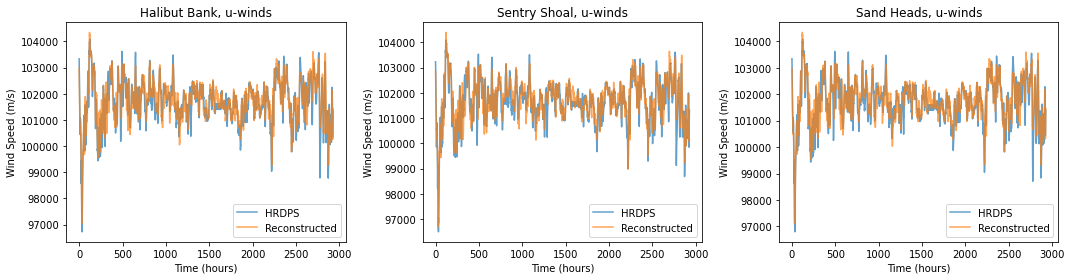

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
alpha_val = 0.7

ax[0].plot(HB, label = "HRDPS", alpha = alpha_val)
ax[0].plot(HB_rec, label = "Reconstructed", alpha = alpha_val)
ax[0].set_title("Halibut Bank, u-winds")
ax[0].set_xlabel("Time (hours)")
ax[0].set_ylabel("Wind Speed (m/s)")
ax[0].legend()

ax[1].plot(SS, label = "HRDPS", alpha = alpha_val)
ax[1].plot(SS_rec, label = "Reconstructed", alpha = alpha_val)
ax[1].set_title("Sentry Shoal, u-winds")
ax[1].set_xlabel("Time (hours)")
ax[1].set_ylabel("Wind Speed (m/s)")
ax[1].legend()

ax[2].plot(SH, label = "HRDPS", alpha = alpha_val)
ax[2].plot(SH_rec, label = "Reconstructed", alpha = alpha_val)
ax[2].set_title("Sand Heads, u-winds")
ax[2].set_xlabel("Time (hours)")
ax[2].set_ylabel("Wind Speed (m/s)")
ax[2].legend()
print("HB RMSE:", np.sqrt( mean_squared_error(HB, HB_rec)), 
                            "SS RMSE:", np.sqrt( mean_squared_error(SS, SS_rec)), 
                                                  "SH RMSE:", np.sqrt( mean_squared_error(SH, SH_rec)))

avg_rmse = np.sqrt( mean_squared_error(HB, HB_rec)) + np.sqrt( mean_squared_error(SS, SS_rec)) + np.sqrt( mean_squared_error(SH, SH_rec))
avg_rmse = avg_rmse/3
print("Average RMSE:", avg_rmse)
plt.tight_layout()

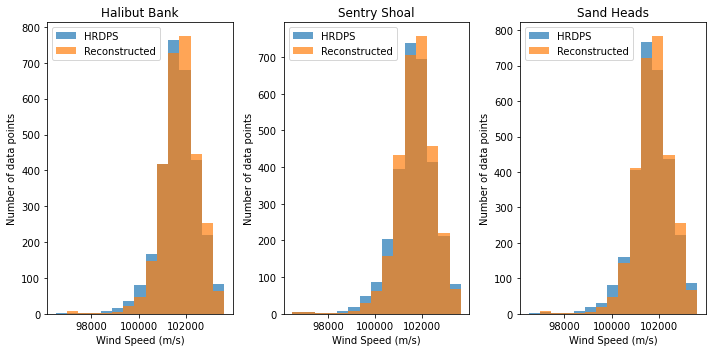

In [9]:
min = np.min([np.min(HB), np.min(SH), np.min(SS)])
max = np.max([np.max(HB), np.max(SH), np.max(SS)])
diff = max - min
nums = np.arange(min, max, (max - min)/16)

fig, ax = plt.subplots(1, 3, figsize=(10, 5))

ax[0].set_title("Halibut Bank")
ax[0].hist(HB, bins = nums, label = "HRDPS", alpha = 0.7)
ax[0].hist(HB_rec, bins = nums, label = "Reconstructed", alpha = 0.7)
ax[0].set_xlabel("Wind Speed (m/s)")
ax[0].set_ylabel("Number of data points")
ax[0].legend()

ax[1].set_title("Sentry Shoal")
ax[1].hist(SS, bins = nums, label = "HRDPS", alpha = 0.7)
ax[1].hist(SS_rec, bins = nums, label = "Reconstructed", alpha = 0.7)
ax[1].set_xlabel("Wind Speed (m/s)")
ax[1].set_ylabel("Number of data points")
ax[1].legend()

ax[2].set_title("Sand Heads")
ax[2].hist(SH, bins = nums,  label = "HRDPS", alpha = 0.7)
ax[2].hist(SH_rec, bins = nums, label = "Reconstructed", alpha = 0.7)
ax[2].set_xlabel("Wind Speed (m/s)")
ax[2].set_ylabel("Number of data points")
ax[2].legend()

plt.tight_layout()

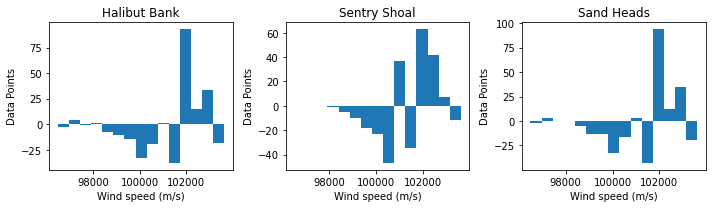

In [10]:
a1 = np.histogram(HB, bins = nums)
b1 = np.histogram(HB_rec, bins = nums)

a2 = np.histogram(SS, bins = nums)
b2 = np.histogram(SS_rec, bins = nums)

a3 = np.histogram(SH, bins = nums)
b3 = np.histogram(SH_rec, bins = nums)

# calc middle of bin and width of bin
axes = [(a1[1][x]+a1[1][x+1])/2 for x in range(len(a1[1])-1)] 
w = a1[1][1] - a1[1][0]
##plot differences
fig, ax = plt.subplots(1, 3, figsize = (10, 3))

ax[0].bar(axes, b1[0] - a1[0], width=w, label="Reconstruct - HRDPS 2008")
ax[0].set_title("Halibut Bank")
ax[1].bar(axes, b2[0] - a2[0], width=w, label="Reconstruct - HRDPS 2008")
ax[1].set_title("Sentry Shoal")
ax[2].bar(axes, b3[0] - a3[0], width=w, label="Reconstruct - HRDPS 2008")
ax[2].set_title("Sand Heads")

for i in range(3):
    ax[i].set_xlabel("Wind speed (m/s)")
    ax[i].set_ylabel("Data Points")
plt.tight_layout()

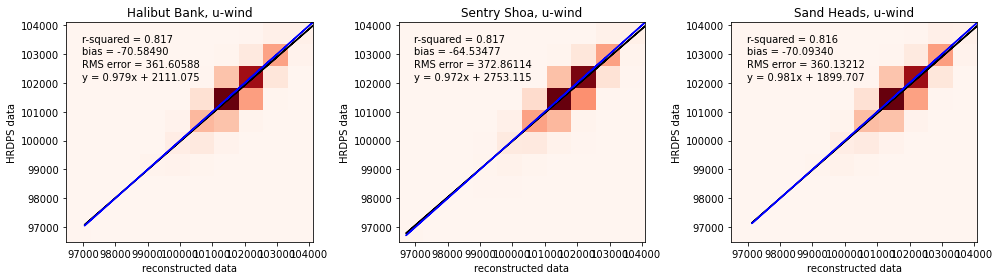

In [11]:
metrics = np.zeros((3, 3))

def helper(x, y, ax, i):
    
    reg = LinearRegression().fit(x.reshape(-1, 1), y)
    a = reg.coef_[0]
    b = reg.intercept_
    y_pred = a*x + b
    
    bias = np.mean( y - x )
    r_squared = reg.score(x.reshape(-1, 1), y)
    rmse = np.sqrt( mean_squared_error(y, y_pred) )
    
    global metrics
    metrics[i, 0] = r_squared
    metrics[i, 1] = bias
    metrics[i, 2] = rmse
    
    im = ax[i].hist2d(x, y, bins = 10, range = [[min, max],[min, max]], cmap=plt.cm.Reds)
    ax[i].plot(x, a*x+b, color = 'black')
    ax[i].plot(x, x, color = 'blue')
    ax[i].annotate("r-squared = {:.3f}".format(r_squared), (min + diff/16, max - diff*3/34))
    ax[i].annotate("bias = {:.5f}".format(bias), (min + diff/16, max - diff*5/34))
    ax[i].annotate("RMS error = {:.5f}".format(rmse), (min + diff/16, max - diff*7/34))
    ax[i].annotate("y = {:.3f}x + {:.3f}".format(a, b), (min + diff/16, max - diff*9/34))
    ax[i].set_ylabel("HRDPS data")
    ax[i].set_xlabel("reconstructed data")
    ##ax[i].set_ylim(-14, 20)
    ##ax[i].set_xlim(-14, 20)
    ## plt.colorbar(im,ax=ax[i,j]) 
    ##https://stackoverflow.com/questions/23876588/matplotlib-colorbar-in-each-subplot

fig, ax = plt.subplots(1, 3, figsize = (14, 4))
##Habibut bank
y = HB
x = HB_rec
ax[0].set_title("Halibut Bank, u-wind")
helper(x, y, ax, 0)

##Sentry Shoal
y = SS
x = SS_rec
ax[1].set_title("Sentry Shoa, u-wind")
helper(x, y, ax, 1)

##Sand Heads
y = SH
x = SH_rec
ax[2].set_title("Sand Heads, u-wind")
helper(x, y, ax, 2)

plt.tight_layout()

In [12]:
print(np.mean(metrics, axis = 0))

[  0.81675112 -68.40435467 364.86637873]


In [13]:
##metrics used to rate fit

ex = np.zeros(b1[0].shape)
rmse = np.sqrt( mean_squared_error(b1[0] - a1[0], ex) )
rmse += np.sqrt( mean_squared_error(b2[0] - a2[0], ex) )
rmse += np.sqrt( mean_squared_error(b3[0] - a3[0], ex) )
rmse_hist = rmse/3
print("histogram rmse:", rmse_hist)
print("   R^2,         bias,       RMSE")
metrics_avg = np.mean(metrics, axis = 0)
print(metrics_avg)
print("Average RMSE:", round(avg_rmse, 8))

histogram rmse: 29.58205520213284
   R^2,         bias,       RMSE
[  0.81675112 -68.40435467 364.86637873]
Average RMSE: 371.69180127


## Exports

In [16]:
dict = {
    "HB_hr" : HB,
    "SS_hr" : SS,
    "SH_hr" : SH,
    "HB_recon" : HB_rec,
    "SS_recon" : SS_rec,
    "SH_recon" : SH_rec,
}

export = pd.DataFrame(dict)

In [ ]:
filepath = '/ocean/arandhawa/MOAD/analysis-armaan/notebooks/recon08_' + data_name + '.csv'
print(filepath)

In [ ]:
## export.to_csv(filepath, index = False, header=True)